### ESTIMACIÓN MEDIANTE KRIGING SIMPLE CON REIMPLEMENTACIÓN DE GSLIB EN PYTHON
#####  por Heber Hernández Guerra, La Serena, Chile 2019

GSLIB es el acrónimo de “Geoestatistical Software Library”, el cual es uno de los primeros directorios contenedores de software geoestadístico en el mundo, desarrollado en el departamento de ingeniería del Petroleo de la Universidad de Stanford. 

Su primera publicación fue en el año 1992, con una amplia colección de algoritmos  para realizar análisis estructural, estimación y simulación geoestadística en dominios espaciales bidimensionales y tridimensionales. 

Algunos investigadores lo consideran como el principal desarrollo informático en la historia de la Geoestadística (Remy, 2009). 

Debido a su diseño modular y su gran eficiencia ha sido empleada como herramienta de enseñanza e investigación en el desarrollo de nuevos algoritmos y metodologías (Deutsch y Journel, 1998; Remy, 2009). 

Su principal desventaja son las limitadas capacidades de visualización de resultados, puesto que solo soporta la visualización mediante archivos Post-Script, además de la inexistencia de una interfaz gráfica freeware de usuario (Wingle et al., 1999).

De lo anterior, es que dada la re implementación de GSLIB en Python por el Dr. Michael J. Pyrcz (https://github.com/GeostatsGuy/GeostatsPy), las limitaciones existentes en cuanto a visualización y los tiempos de las rutinas que hace 20 años atrás eran problema, ya no lo son. 

En el presente notebook, se expone la metodología para una estimación a nivel 2D con Kriging Simple, bajo una presentación regular de muestras distrubuidas en el plano. 

**Bibliotecas a utilizar en el notebook:**

In [4]:
import geostatspy.GSLIB as GSLIB                          # Utilidades GSLIB y funciones envueltas
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import os                                                 # Para configurar el directorio de trabajo
import numpy as np                                        # Biblioteca de funciones matemáticas
import pandas as pd                                       # Biblioteca para manipulación de marcos de datos
import matplotlib.pyplot as plt                           # Biblioteca para salida gráfica
plt.style.use('seaborn')   

**Datos de entrada: 2D [X, Y, Variable]**

In [5]:
ruta ="C:/Users/Heber/Desktop/Demostracion/" #Carpeta en la que se encuentra el archivo de muestras.
archivo ="muestras_ks.csv" #Nombre del archivo de muestras.

In [6]:
os.chdir("C:/Users/Heber/Desktop/Demostracion/GSLIB_FOLDER") # ruta de ejecutables de GSLIB

In [7]:
df = pd.read_csv(ruta + archivo, sep=";") # lectura del conjunto de datos de entrada

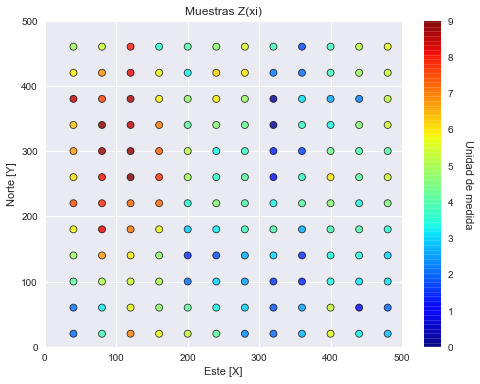

In [8]:
cmap = plt.cm.jet
GSLIB.locmap(df,'X','Y','muestra',0,500,0,500,0,9,'Muestras Z(xi)','Este [X]','Norte [Y]','Unidad de medida',cmap,"fig_title")
plt.show()

In [10]:
# df['muestra'].describe() #estadísticos básicos del DataFrame (oculto)

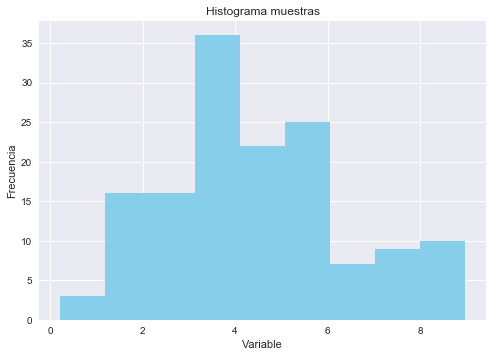

In [11]:
plt.hist(df['muestra'], bins="sturges",color='skyblue', histtype='stepfilled',cumulative=False)
plt.grid(False)
plt.xlabel("Variable")
plt.ylabel("Frecuencia")
plt.title("Histograma muestras")
plt.grid(True)

In [12]:
# df['muestra'].var() #varianza de la variable de interés (oculto)

**Semivariograma Experimental:** Lags, semivarianza, numero de pares 

In [13]:
lag000, vario000, npp000 = GSLIB.gamv_2d(df,'X','Y','muestra',20,40,0,9999,1)
lag090, vario090, npp090 = GSLIB.gamv_2d(df,'X','Y','muestra',20,40,90,1,1)
lagiso, varioiso, nppiso = GSLIB.gamv_2d(df,'X','Y','muestra',20,40,0,90,1)

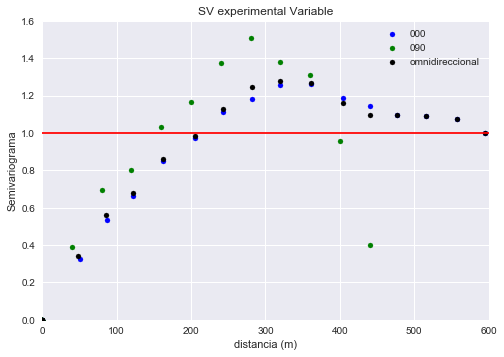

In [14]:
#plt.scatter(lagiso,varioiso,s=25,marker='x',color = 'black',label = 'Iso') # s=nppiso/len(df_tesis)
plt.scatter(lag000,vario000,s=25,marker='o',color = 'blue',label = '000')
plt.scatter(lag090,vario090,s=25,marker='o',color = 'green',label = '090')
plt.scatter(lagiso,varioiso,s=25,marker='o',color = 'black',label = 'omnidireccional')
plt.plot([0,600],[1.0,1.0],color = 'red')
plt.xlabel('distancia (m)')
plt.ylabel('Semivariograma')
plt.title('SV experimental Variable')
plt.ylim(0,1.6)
plt.xlim(0,600)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::], labels[::])


#plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1.0, wspace=0.3, hspace=0.3)
plt.show()

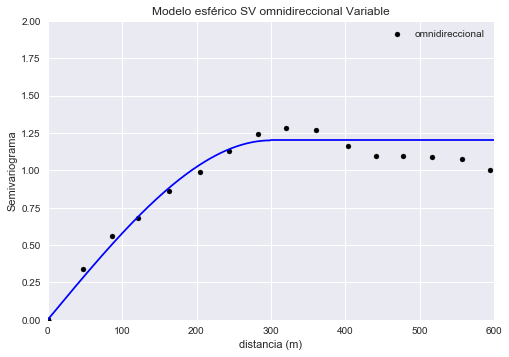

In [15]:
plt.scatter(lagiso,varioiso,s=25,marker='o',color = 'black',label = 'omnidireccional')
plt.plot([300,600],[1.2,1.2],color = 'blue')

x = np.arange(0,300,1)
y = ((1.5*(x/300)) - (0.5*(x/300)**3))*1.2

plt.plot(x,y, color = 'blue')

plt.xlabel('distancia (m)')
plt.ylabel('Semivariograma')
plt.title('Modelo esférico SV omnidireccional Variable')
plt.ylim(0,2)
plt.xlim(0,600)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::], labels[::])

plt.show()

In [16]:
vario_kri = GSLIB.make_variogram(0,1,1,1,0,300,300) #ajuste a modelo variográfico para estimación con Kriging

**Configuración parametros de Kriging:** 

In [20]:
nx = 100; ny = 100; xsiz = 5; ysiz = 5; xmn = 50; ymn = 50; nxdis = 1; nydis = 1
ndmin = 2; ndmax = 10; radius = 300; ktype = 0; skmean = 4.45

tmin = -999; tmax = 999

kmap, vmap = geostats.kb2d(df,'X','Y','muestra',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario_kri)

xmin = 0
ymin = 0
xmax = 500
ymax = 500

  Estimated   10000 blocks 
      average   4.506498599102182  variance  2.903648476704465


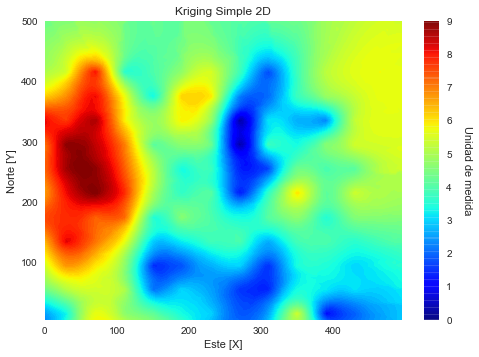

In [21]:
GSLIB.pixelplt_st(kmap,xmin,xmax,ymin,ymax,5,0,9,"Kriging Simple 2D","Este [X]","Norte [Y]","Unidad de medida",cmap)
plt.show()